---
title: "Geo-Spatial Analysis"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: true
    html-math-method: katex
jupyter: python3
---

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

my_colors =['#28AFB0', '#F46036', '#F1E3D3', '#2D1E2F', '#26547C', '#28AFB0']

listings = pd.read_csv("listings_processed.csv") # processed data

Finally, we delve into the realm of machine learning to develop a predictive model aimed at estimating listing prices for Airbnb accommodations in Amsterdam. Leveraging a dataset enriched with a variety of features including location, property type, and amenities, our objective is to build a robust model capable of accurately predicting listing prices.

To ensure the reliability and generalizability of our model, we will employ **k-fold cross-validation** with `k=10`, a widely-used technique for assessing model performance and mitigating overfitting. 

Additionally, we will explore the effectiveness of four distinct machine learning algorithms: `Lasso regression`, `Decision Tree`, `Bagging`, and `Random Forest`. By evaluating the performance of these models against our dataset, we aim to identify the most suitable approach for predicting listing prices. 

# Data Pre-Processing & Splitting

## Pre-processing

In the pre-processing phase, we strategically removed irrelevant variables, including listing names, IDs, host names, and other non-predictive attributes, streamlining the dataset to focus solely on features with direct relevance to price prediction:

In [2]:
listings = listings.drop(columns=["name", "host_id", "host_name", "last_review"])
listings.shape

(6018, 12)

### Categorical Data (dummies)

Additionally, recognizing the significance of categorical features in our analysis, we applied **one-hot encoding** to convert categorical variables into dummies, thereby facilitating their integration into our machine learning models. 

`neighbourhood`, `room_type` are not ordinal, so we will just create dummy variables with them:

In [3]:
#| code-fold: false

listings_1 = pd.get_dummies(listings, columns=['neighbourhood'], drop_first=True)
listings_2 = pd.get_dummies(listings_1, columns=['room_type'], drop_first=True)

listings_2.shape

(6018, 34)

### Feature & Target


Now, we define our features and target variables. The features (`X`) represent the input data used to make predictions, while the target variable (`y`) represents the outcome we seek to predict:

In [4]:
#| code-fold: false

# Defining features and targets
X = listings_2.drop(columns=["price"])
y = listings_2["price"]
print(X.shape, y.shape)

(6018, 33) (6018,)


We extract features by removing the "`price`" column from our dataset `listings_2`, ensuring that our model is trained solely on relevant attributes and does not inadvertently incorporate the target variable during training. 

Subsequently, we isolate the target variable by assigning the "`price`" column to the variable y, delineating the values that our model will endeavor to predict.

### Data Normalization

We recognize the importance of data normalization —a process aimed at standardizing the scale of numerical features within our dataset. To achieve this, we utilize the `MinMaxScaler` from the `sklearn.preprocessing` module, which rescales each feature to a specified range, typically between 0 and 1. 
 
Here, we apply normalization data on: `latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_hosts_listings_count, availability_365, number_of_reviews_ltm`

In [5]:
#| code-fold: false

from sklearn.preprocessing import MinMaxScaler

num_var = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
           'calculated_hosts_listings_count', 'availability_365', 'number_of_reviews_ltm'] ## EXCEPT PRICE

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
pd.DataFrame(X).head(3)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.000000e+00,0.549117,0.693964,0.002,0.139021,0.016939,0.000000,0.120548,0.022602,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.074478e-14,0.547040,0.510564,0.000,0.146384,0.019089,0.047619,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.997292e-14,0.721695,0.502992,0.002,0.106973,0.016222,0.000000,0.038356,0.012217,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Training and Test Data

We will use k-fold Cross Validation by running the `cross_validate` function. Here, we will implement cross validation with a Random Forest classifier and calculate the average test score across `k=10` folds. This is how it works:
- `cv_results = cross_validate(MODEL, X, y, cv=10)`

# Model Training

## A. Linear Regression

We start our modeling endeavors by implementing a **Linear Regression** approach. 

We also compute the **root mean squared error (RMSE)** as a metric of predictive accuracy. Subsequently, we aggregate the RMSE scores obtained from each cross-validation fold to derive an average performance metric.

In [7]:
#| code-fold: false

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# Initialize Linear Regression model
linear_reg = LinearRegression()

# Cross validation and performance evaluation
rmse_ols = cross_validate(linear_reg, X, y, cv=10, scoring='neg_root_mean_squared_error') 

# Average
rmse_ols = pd.DataFrame(rmse_ols)
print( rmse_ols["test_score"].mean() )

-78.22445660007757


## B. Lasso Regression

We also employ **Lasso Regression** —a technique renowned for its ability to perform variable selection and regularization, thereby enhancing model interpretability and generalization. 

Prior to model training, we embark on a hyperparameter tuning process to identify the optimal `alpha` value —a crucial parameter governing the strength of regularization in Lasso Regression.

In [8]:
#| code-fold: false

import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV

# Define a range of alpha values to search over
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]

# Initialize LassoCV model with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5)

# Fit the model
lasso_cv.fit(X, y)

# Get the MSE for each alpha value
mse_values = np.mean(lasso_cv.mse_path_, axis=1)

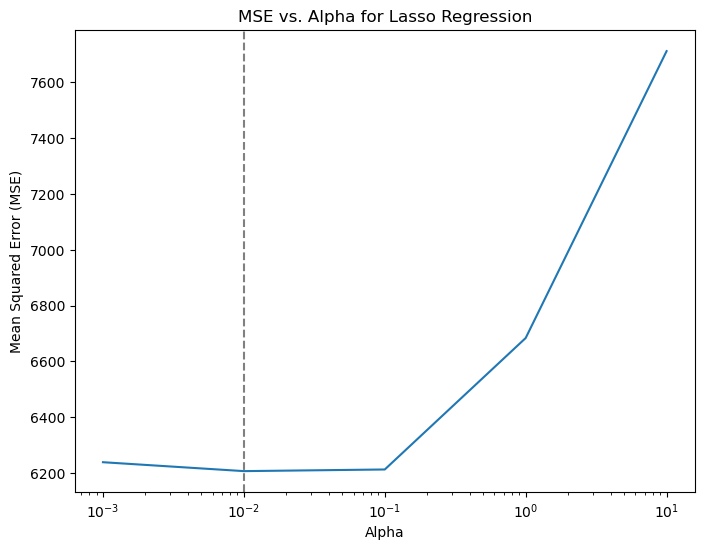

Optimal Alpha: 0.01


In [15]:
#| label: fig-lasso
#| fig-cap: CV Lasso Hyperparameter Tuning

# Plot MSE against alpha
plt.figure(figsize=(8, 6))
plt.plot(lasso_cv.alphas_, mse_values)
plt.axvline(x=0.01, color='grey', linestyle='--')
plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Alpha for Lasso Regression')
plt.grid(False)
plt.show()

print("Optimal Alpha:", lasso_cv.alpha_)

From @fig-lasso, we have identified the optimal hyperparameter for our Lasso Regression model to be `alpha=0.01`. With this optimal alpha value in hand, we are poised to proceed with training our Lasso Regression model:

In [16]:
#| code-fold: false

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

lasso = Lasso(alpha=lasso_cv.alpha_, random_state=42)

# Cross validation and performance evaluation
rmse_lasso = cross_validate(lasso, X, y, cv=10, scoring='neg_root_mean_squared_error') 

# Average
rmse_lasso = pd.DataFrame(rmse_lasso)
print( rmse_lasso["test_score"].mean() )

-78.22394950116399


## C. Decision Tree

For **Decision Trees**, common hyperparameters include the maximum depth of the tree, minimum samples required to split an internal node, minimum samples required to be at a leaf node, and maximum features considered for splitting.

In [109]:
#| cache: true
#| code-fold: false

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for Decision Tree
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Perform grid search cross-validation for Decision Tree
grid_search_dt = GridSearchCV(dt_regressor, param_grid_dt, cv=5, scoring='neg_mean_squared_error')
grid_search_dt.fit(X, y)

# Get the best hyperparameters for Decision Tree
best_params_dt = grid_search_dt.best_params_
print( best_params_dt )

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [ ]:
#| code-fold: false

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

# Initialize Decision Tree Regressor
decision_tree_reg = DecisionTreeRegressor(max_depth = best_params_dt['max_depth'],
                                     min_samples_split = best_params_dt['min_samples_split'],
                                     min_samples_leaf = best_params_dt['min_samples_leaf'],
                                     max_features = best_params_dt['max_features'],
                                     random_state = 42)

# Cross validation and performance evaluation
rmse_tree = cross_validate(decision_tree_reg, X, y, cv=10, scoring='neg_root_mean_squared_error') 

# Average
rmse_tree = pd.DataFrame(rmse_tree)
print( rmse_tree["test_score"].mean() )

## D. Bagging (Ensemble Methods)

For **Bagging**, additional hyperparameters such as the number of base estimators (trees), the number of features to consider, numbere fo samples to draw, etc.

However, here we will use Random Search, due to computational limitations:

In [114]:
#| cache: true
#| code-fold: false

from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


# Define hyperparameters for Bagging
param_dist_bagging = {
    'n_estimators': randint(10, 500),
    'max_samples': [0.5, 0.75, 1.0],
    'max_features': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

# Initialize base estimator (e.g., Decision Tree)
base_estimator = DecisionTreeRegressor(max_depth = best_params_dt['max_depth'],
                                     min_samples_split = best_params_dt['min_samples_split'],
                                     min_samples_leaf = best_params_dt['min_samples_leaf'],
                                     max_features = best_params_dt['max_features'],
                                     random_state = 42)

# Initialize Bagging Regressor
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, random_state=42)


# Perform randomized search cross-validation
random_search_bagging = RandomizedSearchCV(bagging_regressor, param_distributions=param_dist_bagging, n_iter=8, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_bagging.fit(X, y)

# Get the best hyperparameters
best_params_bagging = random_search_bagging.best_params_

print( best_params_bagging )


{'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.75, 'n_estimators': 455}


In [ ]:
#| cache: true
#| code-fold: false

import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate


# Initialize Bagging Regressor with the best hyperparameters
bagging_regressor = BaggingRegressor(base_estimator=base_estimator,
                                     n_estimators=best_params_bagging['n_estimators'],
                                     max_samples=best_params_bagging['max_samples'],
                                     max_features=best_params_bagging['max_features'],
                                     bootstrap=best_params_bagging['bootstrap'],
                                     bootstrap_features=best_params_bagging['bootstrap_features'],
                                     random_state=42)

# Cross validation and performance evaluation
rmse_bagging = cross_validate(bagging_reg, X, y, cv=10, scoring='neg_root_mean_squared_error') 

# Average
rmse_bagging = pd.DataFrame(rmse_bagging)
print( rmse_bagging["test_score"].mean() )

## E. Random Forest (Ensemble Methods)

Finally, we train our **Random Forests** model, where additional hyperparameters such as the number of trees in the forest and the number of features to consider for each split also need to be considered.

In [116]:
#| cache: true
#| code-fold: false

# Define hyperparameters for Random Forest
param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define the hyperparameter grid
#param_dist_rf = {'n_estimators': [10, 50, 100], 
#              'max_features': [None,'sqrt', 'log2'], 'criterion': ['gini','entropy']}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform grid search cross-validation for Random Forest
random_search_rf = RandomizedSearchCV(rf_regressor, param_distributions=param_dist_rf, n_iter=8, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search_rf.fit(X, y)

# Get the best hyperparameters for Random Forest
best_params_rf = random_search_rf.best_params_
print( best_params_rf )

{'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 485}


In [ ]:
#| cache: true
#| code-fold: false

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

# Initialize
rf_regressor = RandomForestRegressor(n_estimators = best_params_rf['n_estimators'],
                                      max_depth = best_params_rf['max_depth'],
                                      min_samples_split = best_params_rf['min_samples_split'],
                                      min_samples_leaf = best_params_rf['min_samples_leaf'],
                                      max_features = best_params_rf['max_features'],
                                      random_state = 42)

# Cross validation and performance evaluation
rmse_rf = cross_validate(rf_regressor, X, y, cv=10, scoring='neg_root_mean_squared_error') 

# Average
rmse_rf = pd.DataFrame(rmse_rf)
print( rmse_rf["test_score"].mean() )

# Performance Evaluation

In the final stage of our analysis, we turn our attention to performance evaluation, where we assess the efficacy of our machine learning models in predicting Airbnb listing prices. To facilitate a comprehensive comparison, we compute the **out-of-sample** (OOS) **root mean squared error** (RMSE) for each model, a widely-used metric for evaluating prediction accuracy. 

We visualize the distribution of OOS RMSE values across different models using boxplots:

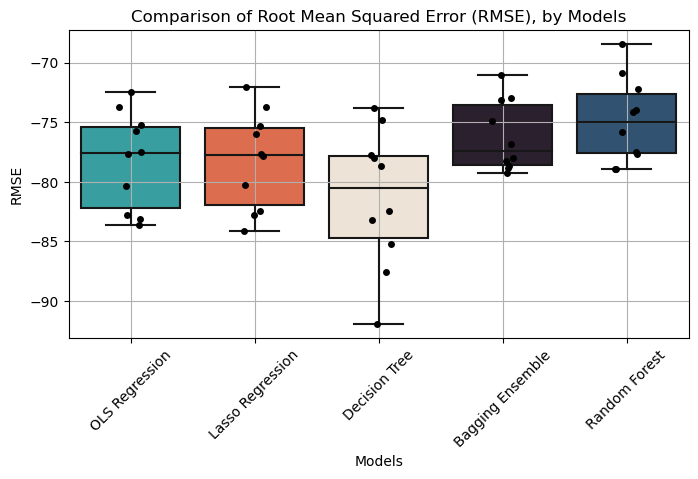

In [119]:
#| label: fig-performance
#| fig-cap: Performance Evaluation

# Concatenate all RMSE scores into a single DataFrame
models = ['OLS Regression', 'Lasso Regression', 'Decision Tree', 'Bagging Ensemble', 'Random Forest']
rmse_scores = [rmse_ols["test_score"], rmse_lasso["test_score"], rmse_tree["test_score"], rmse_bagging["test_score"], rmse_rf["test_score"]]

my_rmse = pd.DataFrame({'Model': [model for model, scores in zip(models, rmse_scores) for _ in scores],
                        'RMSE': np.concatenate(rmse_scores)})

# Colors
my_palette = ['#28AFB0', '#F46036', '#F1E3D3', '#2D1E2F', '#26547C', '#28AFB0']

# Plot box plot using Seaborn
plt.figure(figsize=(8, 4))
sns.boxplot(x='Model', y='RMSE', data=my_rmse, palette=my_palette)
sns.stripplot(x='Model', y='RMSE', data=my_rmse, color='black', jitter=True, size=5)
plt.title('Comparison of Root Mean Squared Error (RMSE), by Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The results in @fig-performance reveals distinct performance profiles among the models, with **Random Forest and Bagging emerging as the top performers**. Not only do these models exhibit better median RMSE values, indicating superior predictive accuracy on average, but they also demonstrate less variance in RMSE, suggesting greater consistency in performance across different data samples. Conversely, the Decision Tree model displays worse RMSE and higher variability in prediction errors, indicating less stable performance across different datasets.

Interestingly, Linear Regression (OLS) and Lasso Regression exhibit similar performance profiles, with comparable median RMSE values and variability. This observation suggests that both models offer similar levels of predictive accuracy for the Amsterdam Airbnb dataset.

Overall, our performance evaluation underscores the superior predictive capabilities of Random Forest and Bagging models, positioning them as preferred choices for accurate and reliable price predictions within the Amsterdam Airbnb market.